# **First run Ocean parcels on SSC fieldset**

In [1]:
%matplotlib inline
import sys
import numpy as np
import xarray as xr
import os
from matplotlib import pyplot as plt, animation, rc
import matplotlib.colors as mcolors
from datetime import datetime, timedelta
from dateutil.parser import parse
from scipy.io import loadmat
from cartopy import crs, feature

from parcels import FieldSet, Field, VectorField, ParticleSet, JITParticle, ErrorCode, AdvectionRK4, AdvectionRK4_3D

rc('animation', html='html5')
from IPython.display import Image

sys.path.append('/home/jvalenti/MOAD/analysis-jose/notebooks/parcels')
from Kernels import DeleteParticle, Buoyancy
from OP_functions import scatter_particles,scatter_particles,make_prefix

## Functions

In [2]:
ss=[]
def mapanimation(fps=1):
    fig = plt.figure(figsize=(19, 8))
    ax = plt.axes(xlim=(-127,-121),ylim=(46.8,51.2))
    ax.contour(coords.nav_lon, coords.nav_lat, mask.mbathy[0,:,:],colors='k',linewidths=0.1)
    ax.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
    ax.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
    ax.grid()
    ax.set_aspect(1/1)
    ax.scatter(clon,clat,c='g', marker='*', linewidths=2)
    plt.ylabel('Latitude',fontsize=16)
    plt.xlabel('Longitude',fontsize=16)
    t = ax.text(0.02, 0.02, '', transform=ax.transAxes)
    t.set_text('')
    ss = scatter_particles(ax, N,n, 0,0, ds.lat,ds.lon)

    def update(frame):
        tstamp = ds.time[0, frame].values.astype('datetime64[s]').astype(datetime)
        t.set_text(tstamp.strftime('%Y-%b-%d %H:%M UTC'))
        global ss
        for scat in ss:
            scat.remove()
        ss = scatter_particles(ax, N,n, frame,frame, ds.lat,ds.lon)
        return ss

    anim= animation.FuncAnimation(fig, update, frames=np.arange(0,len(ds.lon[0,:]),fps))
    return anim

In [3]:
def visual(nmin=0, nmax=-1):
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(19, 8))
    ax1.contour(coords.nav_lon, coords.nav_lat, mask.mbathy[0,:,:],colors='k',linewidths=0.1)
    ax1.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
    ax1.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')

    scatter_particles(ax1, N,n, nmin, nmax, ds.lat,ds.lon)
    ax1.scatter(clon,clat,c='g', marker='*', linewidths=1)

    scatter_particles(ax2, N,n, nmin, nmax, -ds.z,ds.lon)
    ax2.grid()
    plt.ylabel('Depth [m]')
    plt.xlabel('Longitude')
    zsc=np.repeat((dmin-dmax)/2,len(clon))
    ax2.scatter(clon,zsc,c='r', marker='*', linewidths=1)

## Load drifters and definitions

In [4]:
# Define paths
paths = {
    'NEMO': '/results2/SalishSea/nowcast-green.201905/',
    'coords': '/ocean/jvalenti/MOAD/grid/coordinates_seagrid_SalishSea201702.nc',
    'mask': '/ocean/jvalenti/MOAD/grid/mesh_mask201702.nc',
    'out': '/home/jvalenti/MOAD/analysis-jose/notebooks/results',
    'anim': '/home/jvalenti/MOAD/animations'
}

In [5]:
# Duration and timestep [s]
length = 20
duration = timedelta(days=length)
dt = 90 #toggle between - or + to pick backwards or forwards

In [6]:
N = 6 # number of deploying locations
n = 100 # 1000   # number of particles per location
# Define Gaussian point cloud in the horizontal
r = 1000   # radius of particle cloud [m]
deg2m = 111000 * np.cos(50 * np.pi / 180)
var = (r / (deg2m * 3))**2
x_offset, y_offset = np.random.multivariate_normal([0, 0], [[var, 0], [0, var]], [n,N]).T
# Set a uniform distribution in depth, from dmin to dmax
dmin = 0.
dmax = 20.
zvals = dmin + np.random.random_sample([n,N]).T*(dmax-dmin)

## Simulation

In [7]:
start = datetime(2018, 1, 17)
daterange = [start+timedelta(days=i) for i in range(length)]
#Build filenames
Ulist, Vlist, Wlist = [], [], []
for day in range(duration.days):
    path_NEMO = make_prefix(start + timedelta(days=day), paths['NEMO'])
    print (path_NEMO)
    Ulist.append(path_NEMO + '_grid_U.nc')
    Vlist.append(path_NEMO + '_grid_V.nc')
    Wlist.append(path_NEMO + '_grid_W.nc')

# Load NEMO forcing : note, depth aware but no vertical advection, particles stay at their original depth
filenames = {
    'U': {'lon': paths['coords'], 'lat': paths['coords'], 'depth': Wlist[0], 'data': Ulist},
    'V': {'lon': paths['coords'], 'lat': paths['coords'], 'depth': Wlist[0], 'data': Vlist},
    'W': {'lon': paths['coords'], 'lat': paths['coords'], 'depth': Wlist[0], 'data': Wlist},
}
variables = {'U': 'vozocrtx', 'V': 'vomecrty','W': 'vovecrtz'}
dimensions = {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw','time': 'time_counter'}

# bring salish sea results into field_set
field_set = FieldSet.from_nemo(filenames, variables, dimensions, allow_time_extrapolation=True)

         It will be opened with no decoding. Filling values might be wrongly parsed.


/results2/SalishSea/nowcast-green.201905/17jan18/SalishSea_1h_20180117_20180117
/results2/SalishSea/nowcast-green.201905/18jan18/SalishSea_1h_20180118_20180118
/results2/SalishSea/nowcast-green.201905/19jan18/SalishSea_1h_20180119_20180119
/results2/SalishSea/nowcast-green.201905/20jan18/SalishSea_1h_20180120_20180120
/results2/SalishSea/nowcast-green.201905/21jan18/SalishSea_1h_20180121_20180121
/results2/SalishSea/nowcast-green.201905/22jan18/SalishSea_1h_20180122_20180122
/results2/SalishSea/nowcast-green.201905/23jan18/SalishSea_1h_20180123_20180123
/results2/SalishSea/nowcast-green.201905/24jan18/SalishSea_1h_20180124_20180124
/results2/SalishSea/nowcast-green.201905/25jan18/SalishSea_1h_20180125_20180125
/results2/SalishSea/nowcast-green.201905/26jan18/SalishSea_1h_20180126_20180126
/results2/SalishSea/nowcast-green.201905/27jan18/SalishSea_1h_20180127_20180127
/results2/SalishSea/nowcast-green.201905/28jan18/SalishSea_1h_20180128_20180128
/results2/SalishSea/nowcast-green.201905

### Change name for each run!!

In [8]:
# Set output file name.  Maybe change for each run
fn = f'Long-sinking4-MP' + '_'.join(d.strftime('%Y%m%d')+'_1n' for d in [start, start+duration]) + '.nc'
outfile = os.path.join(paths['out'], fn)
print(outfile)

/home/jvalenti/MOAD/analysis-jose/notebooks/results/Long-sinking4-MP20180117_1n_20180206_1n.nc


### Set particle location

In [9]:
lon = np.zeros([N,n])
lat = np.zeros([N,n])
# Execute run
clon, clat = [-123.901172,-125.155849,-123.207648,-122.427508,-123.399769,-123.277731], [49.186308,49.975326,49.305448,47.622403,48.399420,49.11602]  # choose horizontal centre of the particle cloud
for i in range(N):
    lon[i,:]=(clon[i] + x_offset[i,:])
    lat[i,:]=(clat[i] + y_offset[i,:])
z = zvals

In [10]:
# pset = ParticleSet.from_list(field_set, JITParticle, lon=lon, lat=lat, depth=z, time=start+timedelta(hours=2))
# #pset.computeTimeChunk(allow_time_extrapolation=1)
# pset.execute(
#     pset.Kernel(AdvectionRK4_3D), runtime=duration, dt=dt,
#     output_file=pset.ParticleFile(name=outfile, outputdt=timedelta(hours=1)),
#     recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle},
# )

In [11]:
coords = xr.open_dataset(paths['coords'], decode_times=False)
mask = xr.open_dataset(paths['mask'])
ds = xr.open_dataset(outfile)

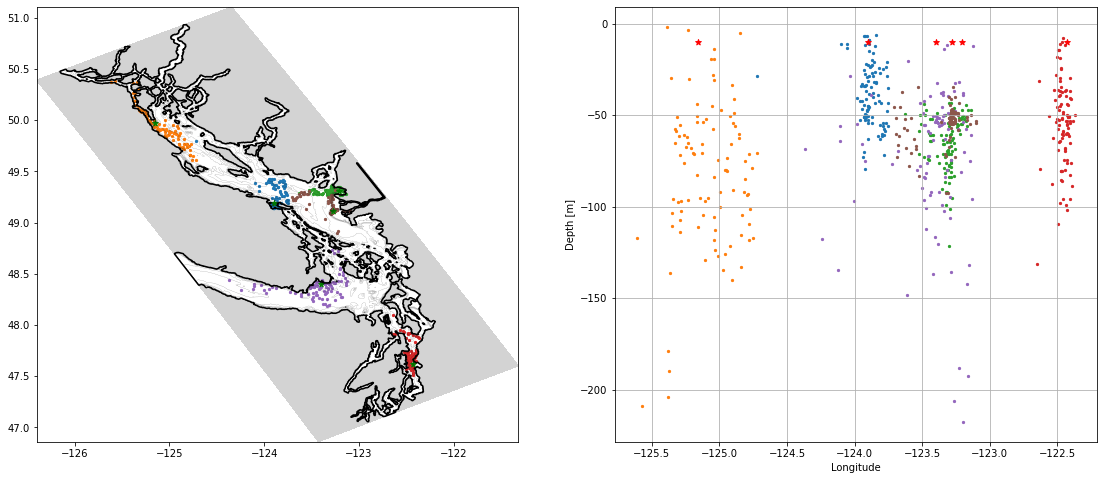

In [12]:
visual(120,120)

In [17]:
#mapanimation(60)

In [32]:
dfield= xr.open_dataset(filenames['U']['depth'][0])
Z = np.array(dfield.depthw)

In [39]:
Z = np.linspace(0,430,200)
Z

array([  0.        ,   2.16080402,   4.32160804,   6.48241206,
         8.64321608,  10.8040201 ,  12.96482412,  15.12562814,
        17.28643216,  19.44723618,  21.6080402 ,  23.76884422,
        25.92964824,  28.09045226,  30.25125628,  32.4120603 ,
        34.57286432,  36.73366834,  38.89447236,  41.05527638,
        43.2160804 ,  45.37688442,  47.53768844,  49.69849246,
        51.85929648,  54.0201005 ,  56.18090452,  58.34170854,
        60.50251256,  62.66331658,  64.8241206 ,  66.98492462,
        69.14572864,  71.30653266,  73.46733668,  75.6281407 ,
        77.78894472,  79.94974874,  82.11055276,  84.27135678,
        86.4321608 ,  88.59296482,  90.75376884,  92.91457286,
        95.07537688,  97.2361809 ,  99.39698492, 101.55778894,
       103.71859296, 105.87939698, 108.04020101, 110.20100503,
       112.36180905, 114.52261307, 116.68341709, 118.84422111,
       121.00502513, 123.16582915, 125.32663317, 127.48743719,
       129.64824121, 131.80904523, 133.96984925, 136.13

In [40]:
starts = np.arange(0,N*n,n)
ends = np.arange(n-1,N*n,n)
time = length*24+1
zn = np.zeros([len(Z)-1,time])

for j in range(time):
    zn[:,j],z_levels = np.histogram(ds.z[:, j], bins=Z)

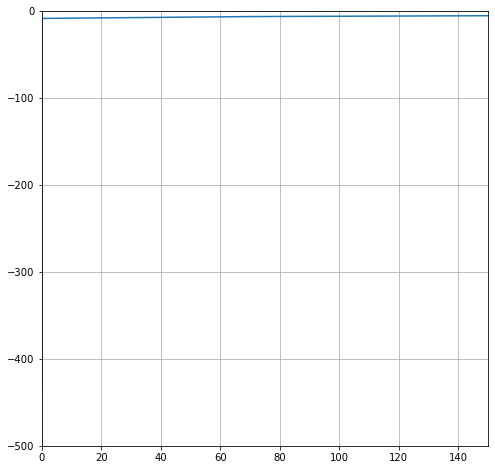

In [45]:
fps=30
fig = plt.figure(figsize=(8, 8))
ss = plt.plot(zn[:,0],-z_levels[1:])
plt.ylabel('Depth [m]',fontsize=16)
plt.xlabel('Number of particles',fontsize=16)
t = ax.text(0.02, 0.02, '', transform=ax.transAxes)
t.set_text('')


def update(frame):
    plt.clf()
    ax = plt.axes(xlim=(0,150),ylim=(-500,0))
    ax.grid()
    tstamp = ds.time[0, frame].values.astype('datetime64[s]').astype(datetime)
    t.set_text(tstamp.strftime('%Y-%b-%d %H:%M UTC'))
    ss = plt.plot(zn[:,frame],-z_levels[1:])
    return ss

anim= animation.FuncAnimation(fig, update, frames=np.arange(0,time,fps))
anim